# Init

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import scipy.stats as st

In [67]:
root_dir = '/tank/projects/omics2022/efimov/scripts/soma_mut/'
datasets_dir = f'{root_dir}/datasets/'
processed_dir = f'{root_dir}/datasets_processed/'
# essentialomes_dir = f'{root_dir}/essentialomes/'

cols_short = ['CHROM', 'POS', 'REF', 'ALT', 'SAMPLE_ID', 'DATASET_ID']
cols_final = ['SAMPLE_ID', 'DONOR_ID', 'AGE', 'SEX', 'CELL_TYPE', 'CELL_SOURCE', 'SNV_BURDEN_RAW', 'SNV_BURDEN', 'INDEL_BURDEN_RAW', 'INDEL_BURDEN', 'AMP', 'DATASET_ID']

mlm_params = {}

# sensitivity_snv_luquette = 46
sensitivity_snv_luquette = 48.7
sensitivity_indel_luquette = 46.2
sensitivity_snv_ganz = 48
sensitivity_indel_ganz = 41

In [68]:
def vcfs_to_counts(vcfs_combined, meta, sample_col='SAMPLE_ID', right_on='sample'):
    counts_df = vcfs_combined \
        .reset_index(names='mut_count') \
        .groupby(sample_col)['mut_count'].count().to_frame() \
        .merge(meta, left_index=True, right_on=right_on)
    return counts_df

In [69]:
def fit_mlm(data, x_var, y_var, group_var, ci_level):
    
    # Fit mixed-effects model: y ~ x + (1 | group)
    formula = f"{y_var} ~ {x_var}"
    # md = smf.mixedlm(formula, data)
    md = smf.mixedlm(formula, data, groups=data[group_var])
    mdf = md.fit(reml=True)
    # print(mdf.params)
    # print(mdf.summary())

    # Extract fixed-effect slope and CI
    slope = mdf.params[x_var]
    pval = mdf.pvalues[x_var]
    se_slope = mdf.bse[x_var]
    z = st.norm.ppf(1 - (1 - ci_level) / 2)
    ci_low, ci_high = slope - z*se_slope, slope + z*se_slope
    
    # Prepare prediction grid
    x_vals = np.linspace(data[x_var].min(), data[x_var].max(), 100)
    intercept = mdf.params['Intercept']

    print(f"Slope = {slope:.3f}, {int(ci_level*100)}% CI = [{ci_low:.3f}, {ci_high:.3f}], Pval = {pval:.1e}, Intercept = {intercept:.3f}")

    # Predicted line and bands
    y_pred = intercept + slope * x_vals
    y_pred_low = intercept + (slope - z*se_slope) * x_vals
    y_pred_high = intercept + (slope + z*se_slope) * x_vals

    # Plot
    plot_df = data[[x_var, y_var]]

    return {'Slope': slope, 'CI_low':ci_low, 'CI_high':ci_high, 'Pval':pval, 'Intercept':intercept, 
            'plot_df':plot_df, 'x_vals':x_vals, 'y_pred':y_pred, 'y_pred_low':y_pred_low, 'y_pred_high':y_pred_high}

In [70]:
outliers = {
    'Brain': ['4638-Neuron-4', 'CT2_PL_Neu2', 'CT2_PL_Neu3'],
    'Heart': ['1039_A1', '1039_A5', '5828_E6'],
    'Liver': [], #['LSC-pcl1', 'LSC-pcl3', 'LSC-pcl4'],
    'Lung': ['N1274_2', 'N1274_8A', 'N1276_4', 'N1407_2', 'N1410_1', 'N1410_6', 'N1415_3']
    }

# Brain

In [71]:
df_motyer = pd.read_csv(f'{datasets_dir}/2025motyer/data/MS_sSNV_burden_data.csv')
df_motyer = df_motyer[(df_motyer['Individual'].str.startswith('CT')) & (~df_motyer['Sample'].isin(outliers['Brain']))].reset_index(drop=True)

df_motyer = df_motyer.rename(columns={c:c.capitalize() for c in df_motyer.columns})
df_motyer = df_motyer.rename(columns={
    'Sample':'SAMPLE_ID', 'Individual':'DONOR_ID', 'Age':'AGE', 'Sex':'SEX', 
    'Ncalls':'SNV_BURDEN_RAW', 'Burden':'SNV_BURDEN', 
    'Wga':'AMP', 'Cell':'CELL_TYPE', 'Region':'CELL_SOURCE'})

df_motyer['SEX'] = df_motyer['SEX'].str.slice(stop=1)

df_motyer

,SAMPLE_ID,DONOR_ID,AMP,Disease,Tissue,CELL_TYPE,CELL_SOURCE,AGE,SEX,Pmi,...,SNV_BURDEN_RAW,Callable.sens,Callable.bp,Callable.burden,Rate.per.gb,SNV_BURDEN,Somatic.sens,Pre.genotyping.burden,Total.ncalls,Eff.sens
0,CT4_FC_Neu2,CT4,PTA,CTL,CTL,Neuron,Frontal cortex,59.0,F,30.0,...,232,0.393965,1286694521,588.885496,228.836560,1337.549953,0.173451,1046,383,0.286344
1,CT4_FC_Neu5,CT4,PTA,CTL,CTL,Neuron,Frontal cortex,59.0,F,30.0,...,193,0.379551,1272848345,508.496220,199.747371,1167.523608,0.165307,1184,399,0.341749
2,CT4_FC_Neu6,CT4,PTA,CTL,CTL,Neuron,Frontal cortex,59.0,F,30.0,...,174,0.368876,1293864559,471.703583,182.284761,1065.454633,0.163311,1110,371,0.348208
3,CT6_FC_Neu10,CT6,PTA,CTL,CTL,Neuron,Frontal cortex,79.0,F,19.0,...,256,0.367261,1311221324,697.051388,265.802338,1553.614969,0.164777,1468,489,0.314750
4,CT6_FC_Neu3,CT6,PTA,CTL,CTL,Neuron,Frontal cortex,79.0,F,19.0,...,271,0.418973,1307849973,646.819148,247.283389,1445.371692,0.187495,1269,514,0.355618
5,CT6_FC_Neu5,CT6,PTA,CTL,CTL,Neuron,Frontal cortex,79.0,F,19.0,...,258,0.391155,1280228404,659.585497,257.604618,1505.699281,0.171349,1269,466,0.309491
6,CT5_FC_Neu10,CT5,PTA,CTL,CTL,Neuron,Frontal cortex,68.0,M,10.0,...,248,0.438414,1291459911,565.675174,219.006091,1280.090852,0.193736,1206,476,0.371849
7,CT5_FC_Neu11,CT5,PTA,CTL,CTL,Neuron,Frontal cortex,68.0,M,10.0,...,265,0.447462,1275690518,592.228856,232.120897,1356.746909,0.195320,1170,477,0.351576
8,CT5_FC_Neu9,CT5,PTA,CTL,CTL,Neuron,Frontal cortex,68.0,M,10.0,...,306,0.495645,1290595356,617.377675,239.183286,1398.026575,0.218880,1149,516,0.369092
9,CT1_PL_Neu6,CT1,PTA,CTL,CTL,Neuron,Parietal lobe,52.1,M,33.0,...,186,0.354460,1259214534,524.742244,208.360939,1217.869922,0.152726,1627,366,0.300525


In [72]:
df_motyer_ext = pd.read_csv(f'{datasets_dir}/2025motyer/external_data/luquette_sSNV_burden_data.csv')
df_motyer_ext = df_motyer_ext.rename(columns={c:c.capitalize() for c in df_motyer_ext.columns})
df_motyer_ext = df_motyer_ext.rename(columns={
    'Sample':'SAMPLE_ID', 'Individual':'DONOR_ID', 'Age':'AGE', 'Sex':'SEX', 
    'Ncalls':'SNV_BURDEN_RAW', 'Burden':'SNV_BURDEN', 
    'Wga':'AMP', 'Cell':'CELL_TYPE', 'Region':'CELL_SOURCE'})

df_motyer_ext = df_motyer_ext[~df_motyer_ext['SAMPLE_ID'].isin(outliers['Brain'])].reset_index(drop=True)
df_motyer_ext['SEX'] = df_motyer_ext['SEX'].str.slice(stop=1)
df_motyer_ext

,SAMPLE_ID,DONOR_ID,AMP,Type,AGE,Color,Plotage,Outlier,Gtype,SEX,...,Callable.burden,Rate.per.gb,SNV_BURDEN,Genome.sens,Total.ncalls,CELL_SOURCE,CELL_TYPE,Disease,Tissue,Eff.sens
0,4643-Neuron-3,4643,PTA,PFC neuron,42.2,#ee82ee,42.2,False,NaN,F,...,549.788824,208.868983,1220.839443,0.152354,343,PFC,Neuron,CTL,CTL,0.280954
1,4643-Neuron-4,4643,PTA,PFC neuron,42.2,#ee82ee,42.2,False,NaN,F,...,363.949667,137.115564,801.440628,0.157217,274,PFC,Neuron,CTL,CTL,0.341884
2,4643-Neuron-6,4643,PTA,PFC neuron,42.2,#ee82ee,42.2,False,NaN,F,...,455.468242,175.332092,1024.816275,0.156126,287,PFC,Neuron,CTL,CTL,0.280050
3,5087PFC-A,5087,PTA,PFC neuron,44.9,#f0e68c,44.9,False,NaN,M,...,329.028044,124.664065,728.661599,0.168803,263,PFC,Neuron,CTL,CTL,0.360936
4,5087PFC-B,5087,PTA,PFC neuron,44.9,#f0e68c,44.9,False,NaN,M,...,426.120689,160.450379,937.832650,0.166341,319,PFC,Neuron,CTL,CTL,0.340146
5,5087PFC-C,5087,PTA,PFC neuron,44.9,#f0e68c,44.9,False,NaN,M,...,295.968107,116.603787,681.549269,0.139388,239,PFC,Neuron,CTL,CTL,0.350672
6,5219-Neuron-2,5219,PTA,PFC neuron,77.0,#ffff00,77.0,False,NaN,F,...,626.466204,234.037734,1367.950821,0.171059,448,PFC,Neuron,CTL,CTL,0.327497
7,5219-Neuron-4,5219,PTA,PFC neuron,77.0,#ffff00,77.0,False,NaN,F,...,608.154807,236.392247,1381.712953,0.150538,431,PFC,Neuron,CTL,CTL,0.311932
8,5219-Neuron-5,5219,PTA,PFC neuron,77.0,#ffff00,77.0,False,NaN,F,...,609.750419,237.484577,1388.097620,0.149125,463,PFC,Neuron,CTL,CTL,0.333550
9,5657PFC-A,5657,PTA,PFC neuron,82.0,#ff00ff,81.0,False,NaN,M,...,621.389790,237.533761,1388.385100,0.146213,380,PFC,Neuron,CTL,CTL,0.273699


In [73]:
meta_luquette = pd.read_csv(f'{datasets_dir}/2022luquette/metadata.csv')
meta_luquette = meta_luquette[(meta_luquette['amp'] == 'PTA') & (~meta_luquette['sample'].isin(outliers['Brain']))].reset_index(drop=True)

data_luquette = pd.read_csv(f'{processed_dir}/2022luquette/2022luquette_hg38.tsv.gz', sep='\t', index_col=None)
data_luquette = data_luquette[data_luquette['SAMPLE_ID'].isin(meta_luquette['sample'].unique())]

df_luquette = vcfs_to_counts(data_luquette, meta_luquette, sample_col='SAMPLE_ID', right_on='sample')
df_luquette['mut_count_adj'] = df_luquette['mut_count']/(sensitivity_snv_luquette/100)

df_luquette = df_luquette.rename(columns={c:c.capitalize() for c in df_luquette.columns})
df_luquette = df_luquette.rename(columns={
    'Sample':'SAMPLE_ID', 'Donor':'DONOR_ID', 'Age':'AGE', 'Sex':'SEX', 
    'Mut_count':'SNV_BURDEN_RAW', 'Mut_count_adj':'SNV_BURDEN', 
    'Amp':'AMP', 'Type':'CELL_TYPE'})
df_luquette[['CELL_SOURCE', 'CELL_TYPE']] = df_luquette['CELL_TYPE'].str.split(' ', expand=True)[::-1]
df_luquette['CELL_TYPE'] = df_luquette['CELL_TYPE'].str.capitalize()

df_luquette = df_luquette[~df_luquette['SAMPLE_ID'].isin(df_motyer_ext['SAMPLE_ID'])].reset_index(drop=True)
df_luquette

,SNV_BURDEN_RAW,SAMPLE_ID,DONOR_ID,AMP,CELL_TYPE,AGE,Color,Plotage,Outlier,Gtype,SEX,Mapd,Imbal,SNV_BURDEN,CELL_SOURCE
0,27,1278BA9-A,1278,PTA,Neuron,0.4,#0000cd,-1.0,False,NaN,M,0.187941,0.171492,55.441478,PFC
1,32,1278BA9-B,1278,PTA,Neuron,0.4,#0000cd,-1.0,False,NaN,M,0.186950,0.172220,65.708419,PFC
2,22,1278BA9-C,1278,PTA,Neuron,0.4,#0000cd,-1.0,False,NaN,M,0.186063,0.179704,45.174538,PFC
3,150,1465BA9-A,1465,PTA,Neuron,17.5,#ffa500,17.5,False,NaN,M,0.207230,0.233048,308.008214,PFC
4,155,1465BA9-B,1465,PTA,Neuron,17.5,#ffa500,17.5,False,NaN,M,0.279514,0.319224,318.275154,PFC
5,163,1465BA9-C,1465,PTA,Neuron,17.5,#ffa500,17.5,False,NaN,M,0.231828,0.252879,334.702259,PFC
6,160,1465BA9-D,1465,PTA,Neuron,17.5,#ffa500,17.5,False,NaN,M,0.271921,0.317050,328.542094,PFC
7,115,4638-Neuron-5,4638,PTA,Neuron,15.1,#191970,15.1,False,NaN,F,0.189251,0.189586,236.139630,PFC
8,158,4638-Neuron-6,4638,PTA,Neuron,15.1,#191970,15.1,False,NaN,F,0.195997,0.203497,324.435318,PFC
9,172,5559PFC-A,5559,PTA,Neuron,19.8,#00ffff,19.8,False,NaN,F,0.209674,0.241154,353.182752,PFC


In [74]:
meta_ganz = pd.read_csv(f'{datasets_dir}/2024ganz/2024ganz_meta_clean.csv', index_col=0)
data_ganz = pd.read_csv(f'{processed_dir}/2024ganz/2024ganz_hg38.tsv.gz', sep='\t', index_col=None)

df_ganz = vcfs_to_counts(data_ganz, meta_ganz, sample_col='SAMPLE_ID', right_on='sample')
df_ganz['mut_count_adj'] = df_ganz['mut_count']/(sensitivity_snv_ganz/100)

df_ganz = df_ganz.rename(columns={c:c.capitalize() for c in df_ganz.columns})
df_ganz = df_ganz.rename(columns={
    'Sample':'SAMPLE_ID', 'Donor':'DONOR_ID', 'Age':'AGE', 'Sex':'SEX', 
    'Mut_count':'SNV_BURDEN_RAW', 'Mut_count_adj':'SNV_BURDEN', 
    'Amp':'AMP', 'Type':'CELL_TYPE'})
df_ganz['CELL_SOURCE'] = 'Gyrus'

df_ganz

,SNV_BURDEN_RAW,DONOR_ID,SAMPLE_ID,AMP,CELL_TYPE,Selection,AGE,Ageclass,Batch,Outlier,SEX,Plotage,Color,SNV_BURDEN,CELL_SOURCE
0,708,190106,190106_Gy_C1,PTA,neuron,NeuN,67.0,elderly,2,NORMAL,M,67.0,black,1475.000000,Gyrus
1,671,190106,190106_Gy_C2,PTA,neuron,NeuN,67.0,elderly,2,NORMAL,M,67.0,black,1397.916667,Gyrus
2,353,301159,301159_Gyrus_D1,PTA,neuron,NeuN,51.0,adult,2,NORMAL,M,51.0,black,735.416667,Gyrus
3,423,301159,301159_Gyrus_D3,PTA,neuron,NeuN,51.0,adult,2,NORMAL,M,51.0,black,881.250000,Gyrus


In [75]:
df_luquette['SAMPLE_ID'].unique().shape

(18,)

In [76]:
df_brain = pd.concat(
    [df_luquette, df_motyer_ext, df_motyer, df_ganz], keys=['LUQUETTE', 'LUQUETTE', 'MOTYER', 'GANZ']) \
    .reset_index(level=0, names='DATASET_ID')[[x for x in cols_final if x in df_luquette.columns or x=='DATASET_ID']].sort_values('AGE').reset_index(drop=True)
print(df_brain['DONOR_ID'].drop_duplicates().shape[0])

df_brain['DONOR_ID'] = df_brain['DONOR_ID'].astype(str).str.replace(r'\D', '', regex=True).astype(int)
print(df_brain['DONOR_ID'].drop_duplicates().shape[0])

df_brain

23
23


,SAMPLE_ID,DONOR_ID,AGE,SEX,CELL_TYPE,CELL_SOURCE,SNV_BURDEN_RAW,SNV_BURDEN,AMP,DATASET_ID
0,1278BA9-A,1278,0.4,M,Neuron,PFC,27,55.441478,PTA,LUQUETTE
1,1278BA9-B,1278,0.4,M,Neuron,PFC,32,65.708419,PTA,LUQUETTE
2,1278BA9-C,1278,0.4,M,Neuron,PFC,22,45.174538,PTA,LUQUETTE
3,5817PFC-B,5817,0.6,M,Neuron,PFC,22,45.174538,PTA,LUQUETTE
4,5817PFC-C,5817,0.6,M,Neuron,PFC,36,73.921971,PTA,LUQUETTE
...,...,...,...,...,...,...,...,...,...,...
60,5823PFC-C,5823,82.7,F,Neuron,PFC,231,1528.529666,PTA,LUQUETTE
61,5823PFC-A,5823,82.7,F,Neuron,PFC,204,1425.057415,PTA,LUQUETTE
62,UMB4976_E3,4976,104.0,F,Neuron,PFC,318,1827.147766,PTA,LUQUETTE
63,UMB4976_E2,4976,104.0,F,Neuron,PFC,263,1535.671126,PTA,LUQUETTE


In [77]:
df_brain['DATASET_ID'].value_counts()

DATASET_ID
LUQUETTE    51
MOTYER      10
GANZ         4
Name: count, dtype: int64

In [78]:
df_brain['SAMPLE_ID'].sort_values().unique()

array(['1278BA9-A', '1278BA9-B', '1278BA9-C', '1465BA9-A', '1465BA9-B',
       '1465BA9-C', '1465BA9-D', '190106_Gy_C1', '190106_Gy_C2',
       '301159_Gyrus_D1', '301159_Gyrus_D3', '4638-Neuron-5',
       '4638-Neuron-6', '4643-Neuron-3', '4643-Neuron-4', '4643-Neuron-6',
       '5087PFC-A', '5087PFC-B', '5087PFC-C', '5219-Neuron-2',
       '5219-Neuron-4', '5219-Neuron-5', '5559PFC-A', '5559PFC-B',
       '5559PFC-C', '5657PFC-A', '5657PFC-B', '5657PFC-C', '5817PFC-A',
       '5817PFC-B', '5817PFC-C', '5823PFC-A', '5823PFC-B', '5823PFC-C',
       '5871-Neuron-4', '5871-Neuron-5', '5871-Neuron-6', '936PFC-A',
       '936PFC-B', '936PFC-C', 'CT1_PL_Neu6', 'CT4_FC_Neu2',
       'CT4_FC_Neu5', 'CT4_FC_Neu6', 'CT5_FC_Neu10', 'CT5_FC_Neu11',
       'CT5_FC_Neu9', 'CT6_FC_Neu10', 'CT6_FC_Neu3', 'CT6_FC_Neu5',
       'UMB4976_E1', 'UMB4976_E2', 'UMB4976_E3', 'UMB5451_B2',
       'UMB5451_B3', 'UMB5451_B5', 'UMB5572_D2', 'UMB5572_D3',
       'UMB5572_D4', 'UMB5666_F1', 'UMB5666_F2', 'UMB5666_

In [79]:
data_brain_indel = pd.concat([pd.read_csv(f'{processed_dir}/2022luquette/2022luquette_indel_hg38.tsv.gz', sep='\t', index_col=None),
                              pd.read_csv(f'{processed_dir}/2024ganz/2024ganz_indel_hg38.tsv.gz', sep='\t', index_col=None)], 
                              keys=['LUQUETTE', 'GANZ']).reset_index(level=[0,1], drop=True)

df_brain_indel = vcfs_to_counts(data_brain_indel, df_brain, 'SAMPLE_ID', 'SAMPLE_ID').reset_index(drop=True)

df_brain_indel = df_brain_indel.rename(columns={'mut_count':'INDEL_BURDEN_RAW'})
df_brain_indel['INDEL_BURDEN'] = df_brain_indel['INDEL_BURDEN_RAW'] * (df_brain_indel['SNV_BURDEN'] / df_brain_indel['SNV_BURDEN_RAW'])

df_brain_indel = df_brain_indel[~df_brain_indel['SAMPLE_ID'].isin(outliers['Brain'])][cols_final].copy()

df_brain_indel

,SAMPLE_ID,DONOR_ID,AGE,SEX,CELL_TYPE,CELL_SOURCE,SNV_BURDEN_RAW,SNV_BURDEN,INDEL_BURDEN_RAW,INDEL_BURDEN,AMP,DATASET_ID
0,1278BA9-A,1278,0.4,M,Neuron,PFC,27,55.441478,4,8.213552,PTA,LUQUETTE
1,1278BA9-B,1278,0.4,M,Neuron,PFC,32,65.708419,2,4.106776,PTA,LUQUETTE
2,1465BA9-A,1465,17.5,M,Neuron,PFC,150,308.008214,27,55.441478,PTA,LUQUETTE
3,1465BA9-B,1465,17.5,M,Neuron,PFC,155,318.275154,21,43.121150,PTA,LUQUETTE
4,1465BA9-C,1465,17.5,M,Neuron,PFC,163,334.702259,31,63.655031,PTA,LUQUETTE
5,1465BA9-D,1465,17.5,M,Neuron,PFC,160,328.542094,21,43.121150,PTA,LUQUETTE
6,190106_Gy_C1,190106,67.0,M,neuron,Gyrus,708,1475.000000,98,204.166667,PTA,GANZ
7,190106_Gy_C2,190106,67.0,M,neuron,Gyrus,671,1397.916667,82,170.833333,PTA,GANZ
8,301159_Gyrus_D1,301159,51.0,M,neuron,Gyrus,353,735.416667,44,91.666667,PTA,GANZ
9,301159_Gyrus_D3,301159,51.0,M,neuron,Gyrus,423,881.250000,49,102.083333,PTA,GANZ


Slope = 17.489, 95% CI = [16.112, 18.865], Pval = 6.0e-137, Intercept = 73.699


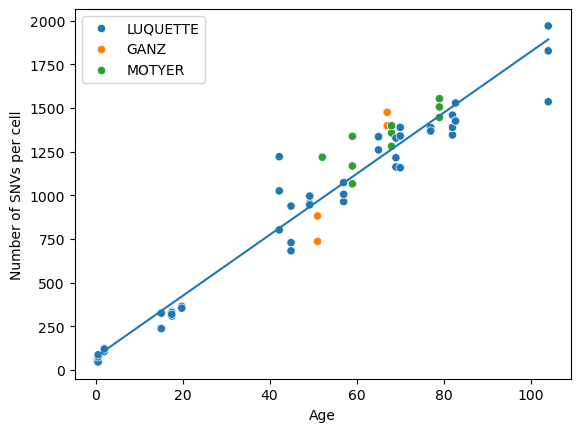

In [80]:
x_var = 'AGE'           # name of predictor column
y_var = 'SNV_BURDEN' # name of response column
group_var = 'DONOR_ID'     # name of grouping column for random effect
ci_level = 0.95         # desired confidence/credible interval level

hue='DATASET_ID'

mlm_params['Brain'] = fit_mlm(data=df_brain, x_var=x_var, y_var=y_var, group_var=group_var, ci_level=ci_level)

slope, ci_low, ci_high, pval, intercept, plot_df, x_vals, y_pred, y_pred_low, y_pred_high = mlm_params['Brain'].values()

fig, axs = plt.subplots(1,1)
# axs = axs.ravel()

ax = axs
sns.scatterplot(df_brain, x=x_var, y=y_var, hue=hue, ax=ax)
sns.lineplot(x=x_vals, y=y_pred, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Number of SNVs per cell')
# ax.fill_between(x_vals, y_pred_low, y_pred_high, alpha=0.2, label=f'{int(ci_level*100)}% CI')
# ax.plot(x_vals, y_pred, label='Fitted mixed-effects model')
# plt.scatter(plot_df[x_var], plot_df[y_var], alpha=0.5)
# plt.plot(x_vals, y_pred, label='Fitted mixed-effects model')
# plt.fill_between(x_vals, y_pred_low, y_pred_high, alpha=0.2, label=f'{int(ci_level*100)}% CI')
# plt.legend()
plt.show()

In [81]:
-np.log(0.5) * 17.350

np.float64(12.026103582715052)

Slope = 6.926, 95% CI = [5.484, 8.367], Pval = 4.6e-21, Intercept = -41.083


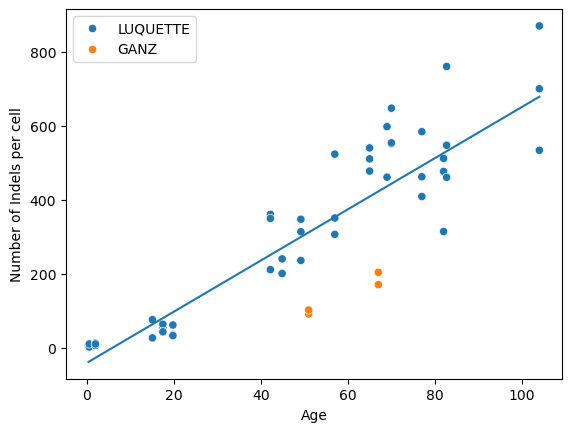

In [82]:
x_var = 'AGE'           # name of predictor column
y_var = 'INDEL_BURDEN' # name of response column
group_var = 'DONOR_ID'     # name of grouping column for random effect
ci_level = 0.95         # desired confidence/credible interval level

hue='DATASET_ID'

mlm_params['Brain_indel'] = fit_mlm(data=df_brain_indel, x_var=x_var, y_var=y_var, group_var=group_var, ci_level=ci_level)

slope, ci_low, ci_high, pval, intercept, plot_df, x_vals, y_pred, y_pred_low, y_pred_high = mlm_params['Brain_indel'].values()

fig, axs = plt.subplots(1,1)

ax = axs
sns.scatterplot(df_brain_indel, x=x_var, y=y_var, hue=hue, ax=ax)
sns.lineplot(x=x_vals, y=y_pred, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Number of Indels per cell')
plt.show()

# Heart

In [83]:
# data_heart = pd.read_csv(f'{processed_dir}/2025choudhury_hg38.tsv.gz', sep='\t', index_col=None)
meta_heart = pd.read_csv(f'{datasets_dir}/2025choudhury/2025choudhury_meta.csv')
per_cell_to_per_gb = (meta_heart['scan2.snv.burden.per.gb'] / meta_heart['scan2.snv.burden.per.cell']).mean()

# df_heart = vcfs_to_counts(data_heart, meta_heart, sample_col='SAMPLE_ID', right_on='Cell_ID')
# df_heart['mut_count_adj'] = df_heart['mut_count']/(sensitivity_snv/100)
# df_heart['gender'] = df_heart['gender'].str.slice(stop=1)

df_heart = meta_heart.copy()
# df_heart['mut_count_adj'] = df_heart['scan2.snv.burden.per.gb']
df_heart['mut_count_adj'] = df_heart['scan2.snv.burden.per.cell']
# df_heart['mut_count_adj'] = np.log10(df_heart['scan2.snv.burden.per.cell'])

df_heart = df_heart.rename(columns={
    'Cell_ID':'SAMPLE_ID', 'Case_ID':'DONOR_ID', 'age':'AGE', 'gender':'SEX', 
    'snv.called.per.cell':'SNV_BURDEN_RAW', 'scan2.snv.burden.per.cell':'SNV_BURDEN'})
df_heart[['AMP', 'CELL_TYPE', 'CELL_SOURCE', 'DATASET_ID']] = ['PTA', 'Cardiomyocyte', 'Left ventricle', 'CHOUDHURY']

df_heart = df_heart[~df_heart['SAMPLE_ID'].isin(outliers['Heart'])][[x for x in cols_final if x in df_heart.columns]].reset_index(drop=True)
df_heart['SEX'] = df_heart['SEX'].str.slice(stop=1)
df_heart

,SAMPLE_ID,DONOR_ID,AGE,SEX,CELL_TYPE,CELL_SOURCE,SNV_BURDEN_RAW,SNV_BURDEN,AMP,DATASET_ID
0,4402_A1,4402,0.2,M,Cardiomyocyte,Left ventricle,70,196.016489,PTA,CHOUDHURY
1,4402_A3,4402,0.2,M,Cardiomyocyte,Left ventricle,49,99.293058,PTA,CHOUDHURY
2,1864_E3,1864,2.0,F,Cardiomyocyte,Left ventricle,125,426.025925,PTA,CHOUDHURY
3,6032_A1,6032,4.0,M,Cardiomyocyte,Left ventricle,143,289.845843,PTA,CHOUDHURY
4,6032_C7,6032,4.0,M,Cardiomyocyte,Left ventricle,123,323.529438,PTA,CHOUDHURY
5,6032_E7,6032,4.0,M,Cardiomyocyte,Left ventricle,156,457.942535,PTA,CHOUDHURY
6,4638_A1,4638,15.1,F,Cardiomyocyte,Left ventricle,220,495.845081,PTA,CHOUDHURY
7,4638_A4,4638,15.1,F,Cardiomyocyte,Left ventricle,392,954.513353,PTA,CHOUDHURY
8,4638_B2,4638,15.1,F,Cardiomyocyte,Left ventricle,283,873.924645,PTA,CHOUDHURY
9,1863_C1,1863,30.0,F,Cardiomyocyte,Left ventricle,109,274.877146,PTA,CHOUDHURY


In [84]:
df_heart.shape

(47, 10)

Slope = 36.369, 95% CI = [19.519, 53.218], Pval = 2.3e-05, Intercept = 97.973


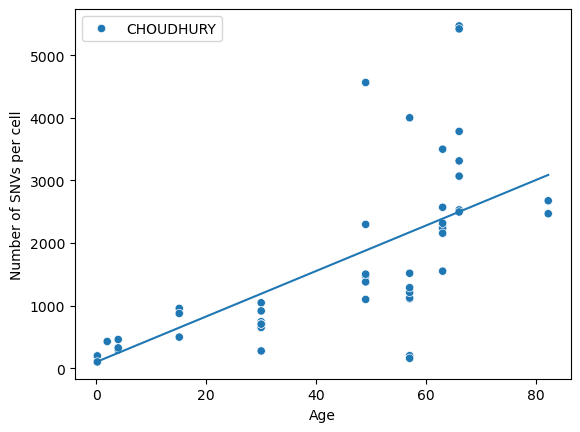

In [85]:
x_var = 'AGE'           # name of predictor column
y_var = 'SNV_BURDEN' # name of response column
group_var = 'DONOR_ID'     # name of grouping column for random effect
ci_level = 0.95         # desired confidence/credible interval level

hue='DATASET_ID'

mlm_params['Heart'] = fit_mlm(data=df_heart, x_var=x_var, y_var=y_var, group_var=group_var, ci_level=ci_level)
slope, ci_low, ci_high, pval, intercept, plot_df, x_vals, y_pred, y_pred_low, y_pred_high = mlm_params['Heart'].values()

fig, axs = plt.subplots(1,1)
# axs = axs.ravel()

ax = axs
sns.scatterplot(df_heart, x=x_var, y=y_var, hue=hue, ax=ax)
sns.lineplot(x=x_vals, y=y_pred, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Number of SNVs per cell')
plt.show()

In [86]:
coef_keys = ['Slope', 'CI_low', 'CI_high', 'Pval', 'Intercept']
snv_to_indel_coefs_ratios_brain_values = np.array([v for k,v in mlm_params['Brain'].items() if k in coef_keys]) / np.array([v for k,v in mlm_params['Brain_indel'].items() if k in coef_keys])
snv_to_indel_coefs_ratios_brain = {k:v for k,v in zip(coef_keys, snv_to_indel_coefs_ratios_brain_values)}
snv_to_indel_coefs_ratios_brain

{'Slope': np.float64(2.525127683982229),
 'CI_low': np.float64(2.937835190469901),
 'CI_high': np.float64(2.254608035989682),
 'Pval': np.float64(1.298946398574321e-116),
 'Intercept': np.float64(-1.7939292914953584)}

In [87]:
mlm_params['Heart_indel'] = {k:(v/snv_to_indel_coefs_ratios_brain[k]) for k,v in mlm_params['Heart'].items() if k in ['Slope', 'CI_low', 'CI_high', 'Pval', 'Intercept']}
mlm_params['Heart_indel']
# mlm_params['Liver_LSC_indel'] = {k:(v/hepatocyte_to_lsc_indel_burden_ratio) for k,v in mlm_params['Liver_indel'].items() if k in ['Slope', 'CI_low', 'CI_high', 'Pval', 'Intercept']}
# mlm_params['Liver_LSC'], mlm_params['Liver_LSC_indel']

{'Slope': np.float64(14.402673731886525),
 'CI_low': np.float64(6.64417272938943),
 'CI_high': np.float64(23.60396797227748),
 'Pval': np.float64(1.794622454492256e+111),
 'Intercept': np.float64(-54.61339003828417)}

# Liver

In [88]:
df_liver = pd.read_excel(f'{datasets_dir}/2020brazhnik_hg38/2020brazhnik_stats_revised.xlsx')
df_liver = df_liver[~df_liver['Sample ID'].isin(['Median', 'SD'])]
df_liver = df_liver.ffill()

df_liver['Age'] = df_liver['Age'].apply(lambda x: float(x.split(' ')[0]) if (('yrs' in x) or ('yes' in x) or ('yr' in x)) else float(x.split(' ')[0])/12 if 'mos' in x else np.nan)
df_liver.columns = df_liver.columns.str.replace(' ', '_').str.strip('_')
df_liver['Sample_ID'] = df_liver['Sample_ID'].str.strip()

df_liver_add = pd.read_excel(f'{datasets_dir}/2020brazhnik_hg38/2020brazhnik_patients_revised.xlsx')
# df_liver_add = df_liver_add[~df_liver_add['Donor ID'].str.contains('LSC')].copy()
# df_liver_add['Donor ID'] = df_liver_add['Donor ID'].apply(lambda x: x.replace('Lonza ', '') if 'Lonza' in x else ).str.replace('Lonza ', '').astype(int)
df_liver['Donor'] = df_liver['Donor'].astype(int)
df_liver_add['Number'] = df_liver_add['Number'].astype(int)

# df_liver = df_liver.merge(df_liver_add[['Donor ID', 'Gender']], how='left', left_on='Donor', right_on='Donor ID')
df_liver = df_liver.merge(df_liver_add[['Number', 'Gender']], how='left', left_on='Donor', right_on='Number')

df_liver = df_liver.rename(columns={
    'Sample_ID':'SAMPLE_ID', 'Donor':'DONOR_ID', 'Age':'AGE', 'Gender':'SEX', 
    'Raw_SNVs_called_(surveyed_genome)':'SNV_BURDEN_RAW', 'SNVs_per_diploid_cell':'SNV_BURDEN'})
df_liver[['AMP', 'CELL_SOURCE', 'DATASET_ID']] = ['MDA', 'Liver', 'BRAZHNIK']
df_liver['CELL_TYPE'] = df_liver['SAMPLE_ID'].apply(lambda x: 'Hepatocyte' if '-H' in x else 'LSC' if 'pcl' in x else 'LSC_derived' if 'kSC' in x else np.nan)

data_liver_indel = pd.concat([pd.read_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_indel.tsv.gz', index_col=None, sep='\t'),
                              pd.read_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_indel_lsc.tsv.gz', index_col=None, sep='\t')])
# data_liver_indel_lsc = 

df_liver = vcfs_to_counts(data_liver_indel, df_liver, sample_col='SAMPLE_ID', right_on='SAMPLE_ID').reset_index(drop=True)
df_liver = df_liver.rename(columns={'mut_count':'INDEL_BURDEN_RAW'})
df_liver['INDEL_BURDEN'] = df_liver['INDEL_BURDEN_RAW'] * (df_liver['SNV_BURDEN'] / df_liver['SNV_BURDEN_RAW'])

df_liver = df_liver[~df_liver['SAMPLE_ID'].isin(outliers['Liver'])][cols_final].copy()
df_liver['SEX'] = df_liver['SEX'].str.slice(stop=1)

df_liver_stem = df_liver[df_liver['CELL_TYPE'] == 'LSC'].reset_index(drop=True)
df_liver = df_liver[df_liver['CELL_TYPE'] == 'Hepatocyte'].reset_index(drop=True)

df_liver

,SAMPLE_ID,DONOR_ID,AGE,SEX,CELL_TYPE,CELL_SOURCE,SNV_BURDEN_RAW,SNV_BURDEN,INDEL_BURDEN_RAW,INDEL_BURDEN,AMP,DATASET_ID
0,L1-H1,5,30.000000,M,Hepatocyte,Liver,649.0,2232.345345,9,30.957023,MDA,BRAZHNIK
1,L1-H2,5,30.000000,M,Hepatocyte,Liver,616.0,2552.078568,11,45.572832,MDA,BRAZHNIK
2,L1-H3,5,30.000000,M,Hepatocyte,Liver,689.0,2742.673302,10,39.806579,MDA,BRAZHNIK
3,L1-H4,5,30.000000,M,Hepatocyte,Liver,645.0,2299.616686,17,60.610052,MDA,BRAZHNIK
4,L10-H1,7,46.000000,F,Hepatocyte,Liver,1138.0,2005.570118,36,63.445100,MDA,BRAZHNIK
5,L10-H2,7,46.000000,F,Hepatocyte,Liver,1061.0,1430.216802,15,20.219842,MDA,BRAZHNIK
6,L10-H3,7,46.000000,F,Hepatocyte,Liver,1315.0,2097.464074,29,46.255862,MDA,BRAZHNIK
7,L10-H4,7,46.000000,F,Hepatocyte,Liver,1579.0,2304.584198,40,58.380854,MDA,BRAZHNIK
8,L11-H1,2,1.333333,F,Hepatocyte,Liver,323.0,704.975733,9,19.643287,MDA,BRAZHNIK
9,L11-H2,2,1.333333,F,Hepatocyte,Liver,655.0,1677.926706,21,53.796123,MDA,BRAZHNIK


In [89]:
df_liver_stem

,SAMPLE_ID,DONOR_ID,AGE,SEX,CELL_TYPE,CELL_SOURCE,SNV_BURDEN_RAW,SNV_BURDEN,INDEL_BURDEN_RAW,INDEL_BURDEN,AMP,DATASET_ID
0,LSC-pcl1,13,1.000000,M,LSC,Liver,868.0,1158.118582,12,16.010856,MDA,BRAZHNIK
1,LSC-pcl3,13,1.000000,M,LSC,Liver,1047.0,1441.807889,9,12.393764,MDA,BRAZHNIK
2,LSC-pcl4,13,1.000000,M,LSC,Liver,1074.0,1467.651750,14,19.131401,MDA,BRAZHNIK
3,LSC4-pcl2,3,18.000000,F,LSC,Liver,469.0,668.831193,2,2.852159,MDA,BRAZHNIK
4,LSC4-pcl2,3,18.000000,F,LSC,Liver,469.0,668.831193,2,2.852159,MDA,BRAZHNIK
5,LSC4-pcl3,3,18.000000,F,LSC,Liver,547.0,768.604442,8,11.241016,MDA,BRAZHNIK
6,LSC4-pcl3,3,18.000000,F,LSC,Liver,547.0,768.604442,8,11.241016,MDA,BRAZHNIK
7,LSC5-pcl1,1,0.416667,M,LSC,Liver,437.0,587.962807,7,9.418169,MDA,BRAZHNIK
8,LSC5-pcl1,1,0.416667,M,LSC,Liver,437.0,587.962807,7,9.418169,MDA,BRAZHNIK
9,LSC5-pcl3,1,0.416667,M,LSC,Liver,485.0,727.700425,2,3.000826,MDA,BRAZHNIK


Slope = 52.783, 95% CI = [36.647, 68.920], Pval = 1.4e-10, Intercept = 572.414


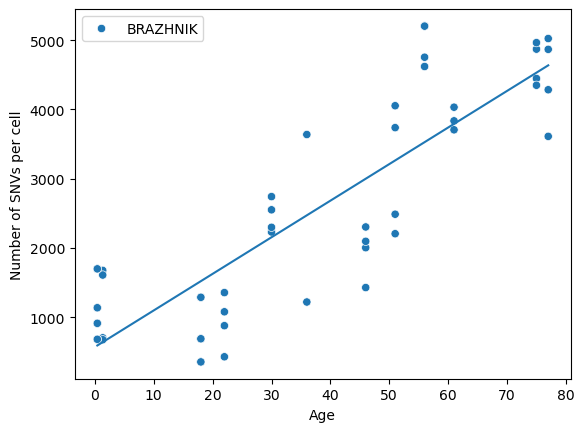

In [90]:
x_var = 'AGE'           # name of predictor column
y_var = 'SNV_BURDEN' # name of response column
group_var = 'DONOR_ID'     # name of grouping column for random effect
ci_level = 0.95         # desired confidence/credible interval level

hue='DATASET_ID'

mlm_params['Liver'] = fit_mlm(data=df_liver, x_var=x_var, y_var=y_var, group_var=group_var, ci_level=ci_level)
slope, ci_low, ci_high, pval, intercept, plot_df, x_vals, y_pred, y_pred_low, y_pred_high = mlm_params['Liver'].values()

fig, axs = plt.subplots(1,1)

ax = axs
sns.scatterplot(df_liver, x=x_var, y=y_var, hue=hue, ax=ax)
sns.lineplot(x=x_vals, y=y_pred, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Number of SNVs per cell')
plt.show()

Slope = 1.158, 95% CI = [0.721, 1.595], Pval = 2.1e-07, Intercept = 9.209


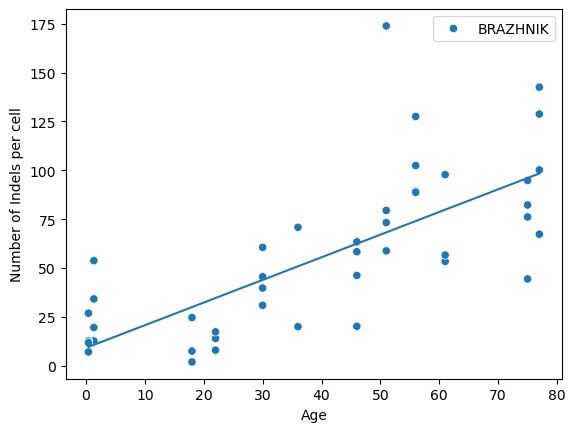

In [91]:
x_var = 'AGE'           # name of predictor column
y_var = 'INDEL_BURDEN' # name of response column
group_var = 'DONOR_ID'     # name of grouping column for random effect
ci_level = 0.95         # desired confidence/credible interval level

hue='DATASET_ID'

mlm_params['Liver_indel'] = fit_mlm(data=df_liver, x_var=x_var, y_var=y_var, group_var=group_var, ci_level=ci_level)
slope, ci_low, ci_high, pval, intercept, plot_df, x_vals, y_pred, y_pred_low, y_pred_high = mlm_params['Liver_indel'].values()

fig, axs = plt.subplots(1,1)

ax = axs
sns.scatterplot(df_liver, x=x_var, y=y_var, hue=hue, ax=ax)
sns.lineplot(x=x_vals, y=y_pred, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Number of Indels per cell')
plt.show()

In [92]:
hepatocyte_to_lsc_snv_burden_ratio = df_liver[df_liver['AGE']<=36]['SNV_BURDEN'].median() / df_liver_stem['SNV_BURDEN'].median()
hepatocyte_to_lsc_indel_burden_ratio = df_liver[df_liver['AGE']<=36]['INDEL_BURDEN'].median() / df_liver_stem['INDEL_BURDEN'].median()
hepatocyte_to_lsc_snv_burden_ratio, hepatocyte_to_lsc_indel_burden_ratio

(np.float64(1.565086874548258), np.float64(1.6707491978585478))

In [93]:
mlm_params['Liver_LSC'] = {k:(v/hepatocyte_to_lsc_snv_burden_ratio) for k,v in mlm_params['Liver'].items() if k in ['Slope', 'CI_low', 'CI_high', 'Pval', 'Intercept']}
mlm_params['Liver_LSC_indel'] = {k:(v/hepatocyte_to_lsc_indel_burden_ratio) for k,v in mlm_params['Liver_indel'].items() if k in ['Slope', 'CI_low', 'CI_high', 'Pval', 'Intercept']}
mlm_params['Liver_LSC'], mlm_params['Liver_LSC_indel']

({'Slope': np.float64(33.72551363703872),
  'CI_low': np.float64(23.415207347044596),
  'CI_high': np.float64(44.03581992703285),
  'Pval': np.float64(9.228738627304715e-11),
  'Intercept': np.float64(365.73947828691723)},
 {'Slope': np.float64(0.693215208727494),
  'CI_low': np.float64(0.43157531148176626),
  'CI_high': np.float64(0.9548551059732218),
  'Pval': np.float64(1.2390462804975373e-07),
  'Intercept': np.float64(5.511657121660529)})

Slope = -16.176, 95% CI = [-83.627, 51.275], Pval = 6.4e-01, Intercept = 1021.476


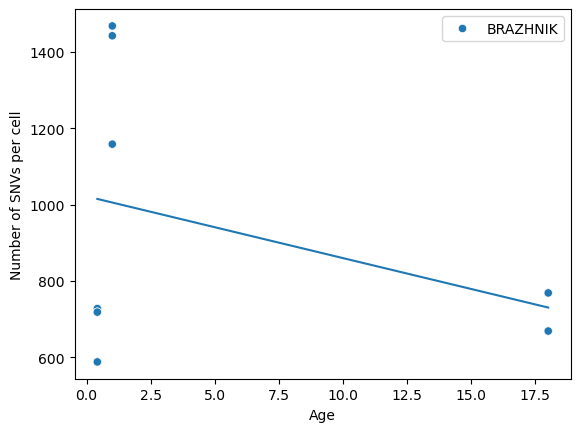

In [94]:
x_var = 'AGE'           # name of predictor column
y_var = 'SNV_BURDEN' # name of response column
group_var = 'DONOR_ID'     # name of grouping column for random effect
ci_level = 0.95         # desired confidence/credible interval level

hue='DATASET_ID'

mlm_params['Liver_stem_mlm'] = fit_mlm(data=df_liver_stem, x_var=x_var, y_var=y_var, group_var=group_var, ci_level=ci_level)
slope, ci_low, ci_high, pval, intercept, plot_df, x_vals, y_pred, y_pred_low, y_pred_high = mlm_params['Liver_stem_mlm'].values()

fig, axs = plt.subplots(1,1)

ax = axs
sns.scatterplot(df_liver_stem, x=x_var, y=y_var, hue=hue, ax=ax)
sns.lineplot(x=x_vals, y=y_pred, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Number of SNVs per cell')
plt.show()

In [95]:
df_liver['SNV_BURDEN'].sum() / df_liver.shape[0] / df_liver['AGE'].max()

np.float64(31.76942575974737)

In [96]:
52.773 * 0.003865

0.203967645

In [97]:
86e9 * (1-0.5) / (16.296565 * 0.00674)

391482619708.937

In [98]:
2e11 / (52.773350 * 0.003865)


980541171483.0079

In [99]:
# x_var = 'Age'
# y_var = 'Corrceted_SNVs_per_diploid_cell_per_mitosis'
# group_var = 'Donor'
# ci_level = 0.95

# fit_mlm(data=meta_liver, x_var=x_var, y_var=y_var, group_var=group_var, ci_level=ci_level)

# Lung

In [100]:
meta_huang = pd.read_excel(f'{datasets_dir}/2022huang_hg38/2022huang_meta.xlsx', sheet_name='Sup_Table2', skiprows=1)
meta_huang = meta_huang[(meta_huang['Smoking_status'] == 'Never_smoking') & (meta_huang['Cancer'].isnull())]

# meta_lung = pd.read_csv(f'{datasets_dir}/2022huang_hg38/2022huang_meta.csv')

df_lung = meta_huang.copy().drop_duplicates('Cell ID')
df_lung['Subject ID'] = df_lung['Subject ID'].astype(str)
# df_lung['SNV_perCell'] = np.log10(df_lung['SNV_perCell'])
# df_lung['INDEL_perCell'] = np.log10(df_lung['INDEL_perCell'])

df_lung = df_lung.rename(columns={
    'Cell ID':'SAMPLE_ID', 'Subject ID':'DONOR_ID', 'Age':'AGE', 'Gender':'SEX', 
    'SNV_raw':'SNV_BURDEN_RAW', 'SNV_perCell':'SNV_BURDEN', 'INDEL_raw':'INDEL_BURDEN_RAW', 'INDEL_perCell':'INDEL_BURDEN'})
df_lung[['AMP', 'CELL_TYPE', 'CELL_SOURCE', 'DATASET_ID']] = ['MDA', 'Bronchial epithelium', 'Bronchus', 'HUANG']

df_lung = df_lung[~df_lung['SAMPLE_ID'].isin(outliers['Lung'])][cols_final].copy()
df_lung['DONOR_ID'] = df_lung['DONOR_ID'].astype(str).str.replace(r'\D', '', regex=True)
df_lung

,SAMPLE_ID,DONOR_ID,AGE,SEX,CELL_TYPE,CELL_SOURCE,SNV_BURDEN_RAW,SNV_BURDEN,INDEL_BURDEN_RAW,INDEL_BURDEN,AMP,DATASET_ID
0,N11_Y_10,11,11,M,Bronchial epithelium,Bronchus,89,463.525360,2,33.976995,MDA,HUANG
1,N11_Y_11,11,11,M,Bronchial epithelium,Bronchus,138,631.724156,5,67.678793,MDA,HUANG
3,N12_Y_8,12,12,M,Bronchial epithelium,Bronchus,104,698.291521,2,37.583601,MDA,HUANG
4,N12_Y_9,12,12,M,Bronchial epithelium,Bronchus,129,1056.082004,4,78.441902,MDA,HUANG
5,N12_Y_11,12,12,M,Bronchial epithelium,Bronchus,68,747.448723,4,106.070574,MDA,HUANG
6,N1407_4,1407,25,F,Bronchial epithelium,Bronchus,458,1791.651492,10,134.943672,MDA,HUANG
7,N1407_7,1407,25,F,Bronchial epithelium,Bronchus,341,1304.219437,12,153.553770,MDA,HUANG
9,N1407_3,1407,25,F,Bronchial epithelium,Bronchus,406,1574.289108,20,224.189149,MDA,HUANG
10,N1295_3,1295,33,M,Bronchial epithelium,Bronchus,107,1715.825416,5,176.191881,MDA,HUANG
11,N1295_5,1295,33,M,Bronchial epithelium,Bronchus,83,1745.618742,3,124.372758,MDA,HUANG


Slope = 28.519, 95% CI = [20.725, 36.312], Pval = 7.4e-13, Intercept = 648.586


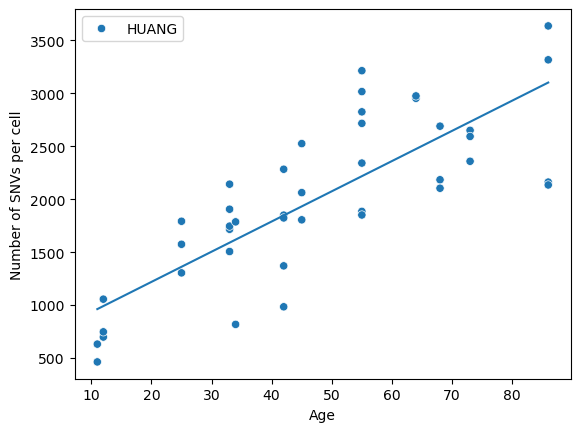

In [101]:
x_var = 'AGE'           # name of predictor column
y_var = 'SNV_BURDEN' # name of response column
group_var = 'DONOR_ID'     # name of grouping column for random effect
ci_level = 0.95         # desired confidence/credible interval level

hue='DATASET_ID'

mlm_params['Lung'] = fit_mlm(data=df_lung, x_var=x_var, y_var=y_var, group_var=group_var, ci_level=ci_level)
slope, ci_low, ci_high, pval, intercept, plot_df, x_vals, y_pred, y_pred_low, y_pred_high = mlm_params['Lung'].values()

fig, axs = plt.subplots(1,1)

ax = axs
sns.scatterplot(df_lung, x=x_var, y=y_var, hue=hue, ax=ax)
sns.lineplot(x=x_vals, y=y_pred, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Number of SNVs per cell')
plt.show()

Slope = 2.573, 95% CI = [1.182, 3.963], Pval = 2.9e-04, Intercept = 58.516


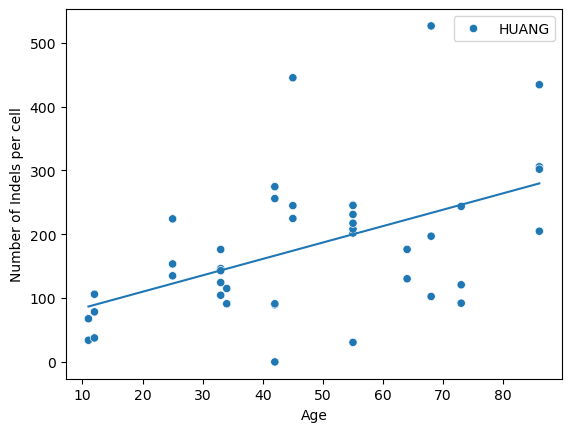

In [102]:
x_var = 'AGE'           # name of predictor column
y_var = 'INDEL_BURDEN' # name of response column
group_var = 'DONOR_ID'     # name of grouping column for random effect
ci_level = 0.95         # desired confidence/credible interval level

hue='DATASET_ID'

mlm_params['Lung_indel'] = fit_mlm(data=df_lung, x_var=x_var, y_var=y_var, group_var=group_var, ci_level=ci_level)
slope, ci_low, ci_high, pval, intercept, plot_df, x_vals, y_pred, y_pred_low, y_pred_high = mlm_params['Lung_indel'].values()

fig, axs = plt.subplots(1,1)

ax = axs
sns.scatterplot(df_lung, x=x_var, y=y_var, hue=hue, ax=ax)
sns.lineplot(x=x_vals, y=y_pred, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Number of Indels per cell')
plt.show()

# FINAL

In [103]:
mlm_params

df_final = pd.DataFrame(
    index=['Slope', 'CI_low', 'CI_high', 'Pval', 'Intercept'],
)
for t in mlm_params.keys():
    df_final[t] = mlm_params[t]['Slope'], mlm_params[t]['CI_low'], mlm_params[t]['CI_high'], mlm_params[t]['Pval'], mlm_params[t]['Intercept']

df_final = df_final.T.copy()

df_final.to_csv(f'{processed_dir}/accumulation_rates_modeled.csv')

def format_values(col):
    if col.name in ['Slope', 'CI_low', 'CI_high', 'Intercept']: ndigits, fmt = 3, 'f'
    elif col.name in ['Pval']: ndigits, fmt = 1, 'e'
    return pd.Series([f"{col[t]:.{ndigits}{fmt}}" for t in col.index], index=col.index)
df_display = df_final.apply(format_values, axis=0)

df_display

,Slope,CI_low,CI_high,Pval,Intercept
Brain,17.489,16.112,18.865,6.0e-137,73.699
Brain_indel,6.926,5.484,8.367,4.6e-21,-41.083
Heart,36.369,19.519,53.218,2.3e-05,97.973
Heart_indel,14.403,6.644,23.604,1.8e+111,-54.613
Liver,52.783,36.647,68.920,1.4e-10,572.414
Liver_indel,1.158,0.721,1.595,2.1e-07,9.209
Liver_LSC,33.726,23.415,44.036,9.2e-11,365.739
Liver_LSC_indel,0.693,0.432,0.955,1.2e-07,5.512
Liver_stem_mlm,-16.176,-83.627,51.275,6.4e-01,1021.476
Lung,28.519,20.725,36.312,7.4e-13,648.586
